In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

import ray
from ray import tune
from ray.air import CheckpointConfig, RunConfig
from ray.air.integrations.wandb import WandbLoggerCallback
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.util.joblib import register_ray

import optuna

import wandb

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    balanced_accuracy_score,
)

In [ ]:
# %conda install -c conda-forge pandas numpy matplotlib ray-tune optuna wandb scikit-learn lightgbm xgboost catboost

In [2]:
IS_RUNNING_LOCALLY = True
SHOULD_SETUP_DATASET = False

DATASET_SUBSET_SIZE = 1_000

In [3]:
FULL_DATASET_PATH = './BindingDB_cleaned_with_mols_&_fingerprints_&_embeddings.pkl'
LOCAL_DATASET_PATH = './BindingDB_cleaned_with_mols_&_fingerprints_&_embeddings_LOCAL_BALANCED.pkl'

In [4]:
INTERACTION_THRESHOLD = 1.8 if IS_RUNNING_LOCALLY else 10
FINGERPRINT_SIZE = 256

HYPERPARAMETER_TUNING_DATASET_SIZE = 0.1

TEST_SIZE = 0.2
VALID_SIZE = 0.2
SEED = 42

N_SPLITS = 3

In [5]:
df = pd.read_pickle(FULL_DATASET_PATH if SHOULD_SETUP_DATASET else LOCAL_DATASET_PATH)

if SHOULD_SETUP_DATASET:
    df_false = df[df['Ki (nM)'] >= INTERACTION_THRESHOLD]
    df_true = df[df['Ki (nM)'] < INTERACTION_THRESHOLD]

    df_false = df_false.sample(
        frac=len(df_true) / len(df_false),
        random_state=SEED,
        replace=False
    )
    df = pd.concat([df_true, df_false], ignore_index=True)

    df = df.sample(DATASET_SUBSET_SIZE, random_state=SEED)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 78217 to 11057
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Monomer ID           1000 non-null   float64
 1   Target ID            1000 non-null   float64
 2   Target type          1000 non-null   object 
 3   Ki (nM)              1000 non-null   float64
 4   Drug SMILES          1000 non-null   object 
 5   Target Sequence      1000 non-null   object 
 6   Mols                 1000 non-null   object 
 7   ECPF                 1000 non-null   object 
 8   Topological Torsion  1000 non-null   object 
 9   Protein Embedding    1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 85.9+ KB


In [6]:
if SHOULD_SETUP_DATASET:
    df.to_pickle('./BindingDB_cleaned_with_mols_&_fingerprints_&_embeddings_LOCAL_BALANCED.pkl')

In [7]:
df["Interaction"] = (df["Ki (nM)"] <= INTERACTION_THRESHOLD).astype(int)

df["Embeddings"] = df.apply(
    lambda x: np.concatenate(
        (
            x["ECPF"].flatten(),
            x["Topological Torsion"].flatten(),
            x["Protein Embedding"],
        )
    ),
    axis=1,
)

X = np.array(list(df["Embeddings"].to_numpy()))
y = df["Interaction"].to_numpy()

In [8]:
X = np.array(list(df["Embeddings"].to_numpy()))
y = df["Interaction"].to_numpy()

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=y,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=VALID_SIZE, random_state=SEED
)

print(
    f"Train set: {X_train.shape}, {y_train.shape}\n"
    f"Validation set: {X_valid.shape}, {y_valid.shape}\n"
    f"Test set: {X_test.shape}, {y_test.shape}"
)

Train set: (640, 832), (640,)
Validation set: (160, 832), (160,)
Test set: (200, 832), (200,)


Based on the amount of records in the datasets, for hyperparameter tuning we will use only 10% of it

In [10]:
if IS_RUNNING_LOCALLY:
    X_hyperparameter_tuning = X
    y_hyperparameter_tuning = y
else:
    X_hyperparameter_tuning, _, y_hyperparameter_tuning, _ = train_test_split(
        X,
        y,
        train_size=HYPERPARAMETER_TUNING_DATASET_SIZE,
        random_state=SEED,
        stratify=y,
    )

print(
    f"Dataset for hyperparameter tuning: {X_hyperparameter_tuning.shape}, {y_hyperparameter_tuning.shape}"
)

Dataset for hyperparameter tuning: (1000, 832), (1000,)


In [11]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class LGBMTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # LightGBM supports eval_set

    fixed_params = {
        "random_state": SEED,
        "n_jobs": -1,
        "verbose": -1,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, LGBMTrainable.fixed_params["random_state"])

        self.model = LGBMClassifier(**config, **LGBMTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if LGBMTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        self.model.booster_.save_model(checkpoint_path)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        self.model._Booster = lgb.Booster(model_file=checkpoint["path"])


In [12]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 200)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("num_leaves", 20, 100)
    trial.suggest_int("max_depth", 3, 10)
    trial.suggest_int("min_child_samples", 5, 20)
    trial.suggest_float("subsample", 0.5, 1.0)
    trial.suggest_float("colsample_bytree", 0.5, 1.0)
    trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    return {}

In [13]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-12 10:48:33,289	INFO worker.py:1888 -- Started a local Ray instance.


In [14]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = LGBMTrainable
STUDY_NAME = "LGBM_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [ ]:
# This is the main function that runs the hyperparameter tuning process.
# It is model and dataset agnostic, it requires only to pass
# the trainable model class, the search space function and other parameters.
def run_tuning(
    trainable_model=TRAINABLE,
    study_name=STUDY_NAME,
    max_train_iters_per_trial=MAX_TRAIN_ITERS_PER_TRIAL,
    metric=METRIC,
    mode=MODE,
    n_trials=N_TRIALS,
    resources=RESOURCES,
    seed=SEED,
):
    # Define the RunConfig
    # It is important to define stop condition!
    run_config = RunConfig(
        callbacks=[
            WandbLoggerCallback(project=f"LSC-{study_name}"),
        ],
        stop={"training_iteration": max_train_iters_per_trial},
        checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
        name=study_name,
    )

    # Define the Optuna search algorithm
    optuna_search = OptunaSearch(
        define_search_space,
        metric=metric,
        mode=mode,
        sampler=optuna.samplers.TPESampler(seed=seed),
        study_name=study_name,
    )

    # Create the Tuner object
    tuner = tune.Tuner(
        tune.with_resources(trainable_model, resources=resources),
        tune_config=tune.TuneConfig(
            scheduler=ASHAScheduler(metric=metric, mode=mode),
            num_samples=n_trials,
            search_alg=optuna_search,
        ),
        run_config=run_config,
    )

    # Start the hyperparameter tuning process
    results = tuner.fit()

    best_result = results.get_best_result(metric=metric, mode=mode)
    best_params = best_result.config
    print(f"Best hyperparameters found: {best_params}")
    best_metric = best_result.metrics[metric]
    print(f"Best {metric} found: {best_metric:.4f}")

    return best_result, results



In [17]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        WandbLoggerCallback(project=f"LSC-{STUDY_NAME}"),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-05 00:15:25,973	INFO wandb.py:321 -- Already logged into W&B.
2025-06-05 00:15:30,250	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.696 s, which may be a performance bottleneck.
2025-06-05 00:15:30,251	WARNING util.py:201 -- The `process_trial_result` operation took 0.698 s, which may be a performance bottleneck.
2025-06-05 00:15:30,251	WARNING util.py:201 -- Processing trial results took 0.698 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-05 00:15:30,252	WARNING util.py:201 -- The `process_trial_result` operation took 0.698 s, which may be a performance bottleneck.
2025-06-05 00:15:34,542	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.782 s, which may be a performance bottleneck.
2025-06-05 00:15:34,543	WARNING util.py:201 -- The `process_trial_result` operation took 0.784 s, which may be a performance bottleneck.
2025-06-05 00:15:34,544	WARNING util.py:201 -- 

Best hyperparameters found: {'n_estimators': 45, 'learning_rate': 0.1269216954106513, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6590017374859319, 'colsample_bytree': 0.5550259622638384, 'reg_alpha': 1.1256839212661599e-06, 'reg_lambda': 6.98184330520185e-05}
Best roc_auc found: 0.7636


In [16]:
lgbm_best_result, _lgbm_all_results = run_tuning(
    trainable_model=LGBMTrainable,
    study_name="LGBM_Optimization",
    max_train_iters_per_trial=20,
    metric="roc_auc",
    mode="max",
    n_trials=20,
    resources={"cpu": 1, "gpu": 0},  # Adjust based on environment
    seed=SEED,
)

lgbm_best_params = {**lgbm_best_result.config, **LGBMTrainable.fixed_params}

2025-06-12 10:48:58,027	INFO wandb.py:321 -- Already logged into W&B.
2025-06-12 10:49:02,179	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.676 s, which may be a performance bottleneck.
2025-06-12 10:49:02,179	WARNING util.py:201 -- The `process_trial_result` operation took 0.677 s, which may be a performance bottleneck.
2025-06-12 10:49:02,180	WARNING util.py:201 -- Processing trial results took 0.677 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-12 10:49:02,180	WARNING util.py:201 -- The `process_trial_result` operation took 0.677 s, which may be a performance bottleneck.
2025-06-12 10:49:05,963	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.971 s, which may be a performance bottleneck.
2025-06-12 10:49:05,964	WARNING util.py:201 -- The `process_trial_result` operation took 0.972 s, which may be a performance bottleneck.
2025-06-12 10:49:05,964	WARNING util.py:201 -- 

Best hyperparameters found: {'n_estimators': 45, 'learning_rate': 0.1269216954106513, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6590017374859319, 'colsample_bytree': 0.5550259622638384, 'reg_alpha': 1.1256839212661599e-06, 'reg_lambda': 6.98184330520185e-05}
Best roc_auc found: 0.7636


In [17]:
# lgbm_best_params = {**best_params, **LGBMTrainable.fixed_params}
lgbm_clf = LGBMClassifier(**lgbm_best_params)
lgbm_clf.fit(
    X_train,
    y_train,
    **({"eval_set": [(X_valid, y_valid)]} if LGBMTrainable.SHOULD_SET_EVAL_SET else {}),
)

y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

/Users/milosz/SemestrVIII/LSC/proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [18]:
lgbm_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("LGBM Classifier Metrics:")
for metric, value in lgbm_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

LGBM Classifier Metrics:
    accuracy: 0.6750
    f1_score: 0.6667
    precision: 0.6701
    recall: 0.6633
    roc_auc: 0.7421
    balanced_accuracy: 0.6748


In [20]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class RFTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = False  # RandomForest does not support eval_set

    fixed_params = {
        "random_state": SEED,
        "n_jobs": -1,
        "verbose": 0,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, RFTrainable.fixed_params["random_state"])

        self.model = RandomForestClassifier(**config, **RFTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if RFTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [21]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 100)
    trial.suggest_int("max_depth", 3, 15)
    trial.suggest_int("min_samples_split", 2, 15)
    trial.suggest_int("min_samples_leaf", 1, 15)
    trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    return {}

In [22]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-05 00:18:31,258	INFO worker.py:1888 -- Started a local Ray instance.


(_WandbLoggingActor pid=2840) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
(_WandbLoggingActor pid=2840) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
(_WandbLoggingActor pid=2840) wandb: Tracking run with wandb version 0.19.11
(_WandbLoggingActor pid=2840) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-18-30_468274_1132/artifacts/2025-06-05_00-18-36/RF_Optimization/driver_artifacts/RFTrainable_e60fe98c_1_max_depth=15,max_features=sqrt,min_samples_leaf=9,min_samples_split=12,n_estimators=44_2025-06-05_00-18-36/wandb/run-20250605_001839-e60fe98c
(_WandbLoggingActor pid=2840) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=2840) wandb: Syncing run RFTrainable_e60fe98c
(_WandbLoggingActor pid=2840) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rni

In [23]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = RFTrainable
STUDY_NAME = "RF_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "balanced_accuracy"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [24]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        WandbLoggerCallback(project=f"LSC-{STUDY_NAME}"),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-05 00:18:36,605	INFO wandb.py:321 -- Already logged into W&B.
2025-06-05 00:18:39,355	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.593 s, which may be a performance bottleneck.
2025-06-05 00:18:39,355	WARNING util.py:201 -- The `process_trial_result` operation took 0.593 s, which may be a performance bottleneck.
2025-06-05 00:18:39,356	WARNING util.py:201 -- Processing trial results took 0.594 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-05 00:18:39,356	WARNING util.py:201 -- The `process_trial_result` operation took 0.594 s, which may be a performance bottleneck.
2025-06-05 00:18:41,108	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.687 s, which may be a performance bottleneck.
2025-06-05 00:18:41,109	WARNING util.py:201 -- The `process_trial_result` operation took 0.688 s, which may be a performance bottleneck.
2025-06-05 00:18:41,109	WARNING util.py:201 -- 

Best hyperparameters found: {'n_estimators': 95, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Best balanced_accuracy found: 0.6993


In [25]:
rf_best_params = {**best_params, **RFTrainable.fixed_params}
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

rf_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("RF Classifier Metrics:")
for metric, value in rf_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

RF Classifier Metrics:
    accuracy: 0.7100
    f1_score: 0.6742
    precision: 0.7500
    recall: 0.6122
    roc_auc: 0.7574
    balanced_accuracy: 0.7081


In [26]:
scale_pos_weight = (y_hyperparameter_tuning == 0).sum() / (
    y_hyperparameter_tuning == 1
).sum()

In [27]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class XGBTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # XGBoost supports eval_set

    fixed_params = {
        "scale_pos_weight": scale_pos_weight,
        "eval_metric": "logloss",
        "random_state": SEED,
        "n_jobs": -1,
        "verbosity": 0,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, XGBTrainable.fixed_params["random_state"])

        self.model = XGBClassifier(**config, **XGBTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if XGBTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [28]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("n_estimators", 10, 100)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("max_depth", 3, 12)
    trial.suggest_float("min_child_weight", 1, 10)
    trial.suggest_float("gamma", 0, 5)
    trial.suggest_float("subsample", 0.5, 1.0)
    trial.suggest_float("colsample_bytree", 0.5, 1.0)
    trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    return {}

In [ ]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-05 00:20:42,954	INFO worker.py:1888 -- Started a local Ray instance.


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61132
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.60837
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60593
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.61216
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60549
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60272
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.59949
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.59999
(XGBTrainable pid=3697) [14]	validation_0-logloss:0.59429
(XGBTrainable pid=3697) [15]	validation_0-logloss:0.59280
(XGBTrainable pid=3697) [16]	validation_0-logloss:0.58921
(XGBTrainable pid=3697) 

(_WandbLoggingActor pid=3692) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
(_WandbLoggingActor pid=3692) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66941
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.65695
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.64621
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.63034
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.60405
(XGBTrainable pid=3697) [14]	validation_0-logloss:0.60027
(XGBTrainable pid=3697) [15]	validation_0-logloss:0.60265
(XGBTrainable pid=3697) [16]	validation_0-logloss:0.60067
(XGBTrainable pid=3697) 

(_WandbLoggingActor pid=3692) wandb: Tracking run with wandb version 0.19.11
(_WandbLoggingActor pid=3692) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_f23574c0_1_colsample_bytree=0.5290,gamma=0.7801,learning_rate=0.2022,max_depth=10,min_child_weight=6.3879,n_estimator_2025-06-05_00-20-46/wandb/run-20250605_002049-f23574c0
(_WandbLoggingActor pid=3692) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=3692) wandb: Syncing run XGBTrainable_f23574c0
(_WandbLoggingActor pid=3692) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization
(_WandbLoggingActor pid=3692) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization/runs/f23574c0


(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.60405
(XGBTrainable pid=3697) [14]	validation_0-logloss:0.60027
(XGBTrainable pid=3697) [15]	validation_0-logloss:0.60265
(XGBTrainable pid=3697) [16]	validation_0-logloss:0.60067
(XGBTrainable pid=3697) [17]	validation_0-logloss:0.60240
(XGBTrainable pid=3697) [18]	validation_0-logloss:0.60134
(XGBTrainable pid=3697) [19]	validation_0-logloss:0.60294
(XGBTrainable pid=3697) [20]	validation_0-logloss:0.60329
(XGBTrainable pid=3697) [21]	validation_0-logloss:0.60271
(XGBTrainable pid=3

(XGBTrainable pid=3699) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_e1f1a35a_2_colsample_bytree=0.5917,gamma=1.0617,learning_rate=0.0001,max_depth=12,min_child_weight=8.4920,n_estimator_2025-06-05_00-20-47/checkpoint_000000)


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69275
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3706) [3]	validation_0-logloss:0.69228
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61132
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.60837
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60593
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.61216
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60549
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60272
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.59949
(XGBTrainable pid=3697) [13]

(_WandbLoggingActor pid=3687) wandb: uploading config.yaml


(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.60405
(XGBTrainable pid=3697) [14]	validation_0-logloss:0.60027
(XGBTrainable pid=3697) [15]	validation_0-logloss:0.60265
(XGBTrainable pid=3697) [16]	validation_0-logloss:0.60067
(XGBTrainable pid=3697) [17]	validation_0-logloss:0.60240
(XGBTrainable pid=3697) [18]	validation_0-logloss:0.60134
(XGBTrainable pid=3697) [19]	validation_0-logloss:0.60294
(XGBTrainable pid=3697) [20]	validation_0-logloss:0.60329
(XGBTrainable pid=3697) [21]	validation_0-logloss:0.60271
(XGBTrainable pid=3

(_WandbLoggingActor pid=3687) wandb:                                                                                
(_WandbLoggingActor pid=3687) wandb: 
(_WandbLoggingActor pid=3687) wandb: Run history:
(_WandbLoggingActor pid=3687) wandb:                 accuracy ▁
(_WandbLoggingActor pid=3687) wandb:        balanced_accuracy ▁
(_WandbLoggingActor pid=3687) wandb:                 f1_score ▁
(_WandbLoggingActor pid=3687) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=3687) wandb:                     loss ▁
(_WandbLoggingActor pid=3687) wandb:                precision ▁
(_WandbLoggingActor pid=3687) wandb:                   recall ▁
(_WandbLoggingActor pid=3687) wandb:                  roc_auc ▁
(_WandbLoggingActor pid=3687) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=3687) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=3687) wandb:             time_total_s ▁
(_WandbLoggingActor pid=3687) wandb:                timestamp ▁
(_WandbLoggingActor pid=368

(XGBTrainable pid=3756) [22]	validation_0-logloss:0.67083
(XGBTrainable pid=3756) [23]	validation_0-logloss:0.66976
(XGBTrainable pid=3756) [24]	validation_0-logloss:0.66942
(XGBTrainable pid=3756) [25]	validation_0-logloss:0.66864
(XGBTrainable pid=3756) [26]	validation_0-logloss:0.66776
(XGBTrainable pid=3756) [27]	validation_0-logloss:0.66696
(XGBTrainable pid=3756) [28]	validation_0-logloss:0.66611
(XGBTrainable pid=3756) [29]	validation_0-logloss:0.66506
(XGBTrainable pid=3756) [30]	validation_0-logloss:0.66393
(XGBTrainable pid=3756) [31]	validation_0-logloss:0.66308
(XGBTrainable pid=3756) [32]	validation_0-logloss:0.66192
(XGBTrainable pid=3756) [33]	validation_0-logloss:0.66173
(XGBTrainable pid=3756) [34]	validation_0-logloss:0.66094
(XGBTrainable pid=3756) [35]	validation_0-logloss:0.66010
(XGBTrainable pid=3756) [36]	validation_0-logloss:0.65939
(XGBTrainable pid=3756) [37]	validation_0-logloss:0.65834
(XGBTrainable pid=3756) [38]	validation_0-logloss:0.65754
(XGBTrainable 

(_WandbLoggingActor pid=3691) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 3x across cluster]


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66941
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.65695
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.64621
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.63034
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69288
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69269
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3766) [17]	validation_0-logloss:0.69256
(XGBTrainable pid=3766) [18

(_WandbLoggingActor pid=3691) wandb: Tracking run with wandb version 0.19.11 [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_af285592_4_colsample_bytree=0.9744,gamma=0.8526,learning_rate=0.0115,max_depth=3,min_child_weight=6.4679,n_estimators_2025-06-05_00-20-50/wandb/run-20250605_002053-af285592 [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: Run `wandb offline` to turn off syncing. [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: Syncing run XGBTrainable_af285592 [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 3x across cluster]
(_WandbLoggingActor pid=3691) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69275
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3706) [3]	validation_0-logloss:0.69228
(XGBTrainable pid=3706) [4]	validation_0-logloss:0.69212
(XGBTrainable pid=3814) [0]	validation_0-logloss:0.69296
(XGBTrainable pid=3814) [1]	validation_0-logloss:0.69284
(XGBTrainable pid=3814) [2]	validation_0-logloss:0.69267
(XGBTrainable pid=3814) [3]	validation_0-logloss:0.69250
(XGBTrainable pid=3814) [4]	validation_0-logloss:0.69226
(XGBTrainable pid=3814) [5]	validation_0-logloss:0.69212
(XGBTrainable pid=3814) [6]	validation_0-logloss:0.69193
(XGBTrainable pid=3814) [7]	val

(XGBTrainable pid=3766) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_6adc5024_5_colsample_bytree=0.5172,gamma=0.6102,learning_rate=0.0002,max_depth=9,min_child_weight=4.9614,n_estimators_2025-06-05_00-20-52/checkpoint_000000) [repeated 2x across cluster]


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66941
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.65695
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.64621
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.63034
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.60405
(XGBTrainable pid=3706) [37]	validation_0-logloss:0.68533
(XGBTrainable pid=3706) [38]	validation_0-logloss:0.68511
(XGBTrainable pid=3706) [39]	validation_0-logloss:0.68488
(XGBTrainable pid=3706) 

(_WandbLoggingActor pid=3691) wandb: uploading config.yaml


(XGBTrainable pid=3706) [8]	validation_0-logloss:0.69136
(XGBTrainable pid=3706) [9]	validation_0-logloss:0.69118
(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69106
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69088
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69063
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69038
(XGBTrainable pid=3706) [14]	validation_0-logloss:0.69017
(XGBTrainable pid=3706) [15]	validation_0-logloss:0.68998
(XGBTrainable pid=3706) [16]	validation_0-logloss:0.68978
(XGBTrainable pid=3706) [17]	validation_0-logloss:0.68951
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.62783
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.62263
(XGBTrainable pid=3823) [8]	validation_0-logloss:0.62378
(XGBTrainable pid=3823) [9]	validation_0-logloss:0.62087
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.62389
(XGBTrainable pid=3823) [11]	validation_0-logloss:0.62127
(XGBTrainable pid=3823) [12]	validation_0-logloss:0.61790
(XGBTrainable pid=38

(_WandbLoggingActor pid=3813) wandb: uploading config.yaml


(XGBTrainable pid=3706) [26]	validation_0-logloss:0.68779
(XGBTrainable pid=3706) [27]	validation_0-logloss:0.68757
(XGBTrainable pid=3706) [28]	validation_0-logloss:0.68735
(XGBTrainable pid=3706) [29]	validation_0-logloss:0.68712
(XGBTrainable pid=3706) [30]	validation_0-logloss:0.68678
(XGBTrainable pid=3706) [31]	validation_0-logloss:0.68661
(XGBTrainable pid=3706) [32]	validation_0-logloss:0.68644
(XGBTrainable pid=3706) [33]	validation_0-logloss:0.68616
(XGBTrainable pid=3706) [34]	validation_0-logloss:0.68598
(XGBTrainable pid=3706) [35]	validation_0-logloss:0.68573
(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67314
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.65753
(XGBTrainable pid=3823) [2]	validation_0-logloss:0.65634
(XGBTrainable pid=3823) [3]	validation_0-logloss:0.64598
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63467
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.63263
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.62420
(XGBTrainable pid=382

(_WandbLoggingActor pid=3813) wandb:  [repeated 10x across cluster]
(_WandbLoggingActor pid=3813) wandb: Run history: [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                 accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:        balanced_accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                 f1_score ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb: iterations_since_restore ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                     loss ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                precision ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                   recall ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:                  roc_auc ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3813) wandb:       time_since_restore ▁ [repeated 2x across cluster]
(_WandbLoggingAc

(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69262
(XGBTrainable pid=3706) [3]	validation_0-logloss:0.69246
(XGBTrainable pid=3706) [4]	validation_0-logloss:0.69229
(XGBTrainable pid=3706) [5]	validation_0-logloss:0.69205
(XGBTrainable pid=3706) [6]	validation_0-logloss:0.69181
(XGBTrainable pid=3706) [7]	validation_0-logloss:0.69161
(XGBTrainable pid=3706) [8]	validation_0-logloss:0.69136
(XGBTrainable pid=3706) [9]	validation_0-logloss:0.69112
(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69090
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69064
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69043
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69026
(XGBTrainable pid=3706) [14]	validation_0-logloss:0.69011
(XGBTrainable pid=3706) [15]	validation_0-logloss:0.68992
(XGBTrainable pid=3706) [16]	validation_0-logloss:0.68978
(XGBTrainable pid=3706) [17]	validation_0-logloss:0.68960
(XGBTrainable pid=3706) [18]	validation_0-logloss:0.68943
(XGBTrainable pid=3706

(_WandbLoggingActor pid=3864) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 3x across cluster]


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61132
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.60837
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60593
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.61216
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60549
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60272
(XGBTrainable pid=3706) [34]	validation_0-logloss:0.68598
(XGBTrainable pid=3706) [35]	validation_0-logloss:0.68573
(XGBTrainable pid=3706) [36]	validation_0-logloss:0.68556
(XGBTrainable pid=3706) [37]	validation_0-logloss:0.68533
(XGBTrainable pid=3706) [38]	validation_0-logloss:0.68511
(XGBTrainable pid=3706) 

(_WandbLoggingActor pid=3864) wandb: Tracking run with wandb version 0.19.11 [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_48c7c162_7_colsample_bytree=0.6943,gamma=0.2261,learning_rate=0.1605,max_depth=3,min_child_weight=2.7638,n_estimators_2025-06-05_00-20-55/wandb/run-20250605_002058-48c7c162 [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: Run `wandb offline` to turn off syncing. [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: Syncing run XGBTrainable_48c7c162 [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 3x across cluster]
(_WandbLoggingActor pid=3864) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=3697) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.65695
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.64621
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.63034
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.62524
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61405
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.61237
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60517
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.60979
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60825
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.60498
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.60405
(XGBTrainable pid=3697) [14]	validation_0-logloss:0.60027
(XGBTrainable pid=3697) [15]	validation_0-logloss:0.60265
(XGBTrainable pid=3697) [16]	validation_0-logloss:0.60067
(XGBTrainable pid=3697) [17]	validation_0-logloss:0.60240
(XGBTrainable pid=3697)

(XGBTrainable pid=3865) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_2864981b_8_colsample_bytree=0.9934,gamma=4.0110,learning_rate=0.0009,max_depth=8,min_child_weight=2.2683,n_estimators_2025-06-05_00-20-57/checkpoint_000000)


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3904) [0]	validation_0-logloss:0.68563
(XGBTrainable pid=3904) [1]	validation_0-logloss:0.67801
(XGBTrainable pid=3904) [2]	validation_0-logloss:0.67264
(XGBTrainable pid=3904) [3]	validation_0-logloss:0.66507
(XGBTrainable pid=3904) [4]	validation_0-logloss:0.65914
(XGBTrainable pid=3904) [5]	validation_0-logloss:0.65553
(XGBTrainable pid=3904) [6]	validation_0-logloss:0.64477
(XGBTrainable pid=3904) [7]	validation_0-logloss:0.63986
(XGBTrainable pid=3904) [8]	validation_0-logloss:0.63548
(XGBTrainable pid=3904) [9]	validation_0-logloss:0.63366
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	val

(_WandbLoggingActor pid=3901) wandb: uploading config.yaml


(XGBTrainable pid=3697) [22]	validation_0-logloss:0.60552
(XGBTrainable pid=3697) [23]	validation_0-logloss:0.60259
(XGBTrainable pid=3697) [24]	validation_0-logloss:0.59858
(XGBTrainable pid=3697) [25]	validation_0-logloss:0.60079
(XGBTrainable pid=3697) [26]	validation_0-logloss:0.60445
(XGBTrainable pid=3697) [27]	validation_0-logloss:0.60174
(XGBTrainable pid=3697) [28]	validation_0-logloss:0.60490
(XGBTrainable pid=3697) [29]	validation_0-logloss:0.60674
(XGBTrainable pid=3697) [30]	validation_0-logloss:0.60976
(XGBTrainable pid=3697) [31]	validation_0-logloss:0.60967
(XGBTrainable pid=3697) [32]	validation_0-logloss:0.60608
(XGBTrainable pid=3697) [33]	validation_0-logloss:0.60359
(XGBTrainable pid=3697) [34]	validation_0-logloss:0.61144
(XGBTrainable pid=3697) [35]	validation_0-logloss:0.61106
(XGBTrainable pid=3697) [36]	validation_0-logloss:0.61069
(XGBTrainable pid=3697) [37]	validation_0-logloss:0.61299
(XGBTrainable pid=3697) [38]	validation_0-logloss:0.61522
(XGBTrainable 

(_WandbLoggingActor pid=3901) wandb:                                                                                 [repeated 6x across cluster]
(_WandbLoggingActor pid=3822) wandb: Run history:
(_WandbLoggingActor pid=3822) wandb:                 accuracy ▁
(_WandbLoggingActor pid=3822) wandb:        balanced_accuracy ▁
(_WandbLoggingActor pid=3822) wandb:                 f1_score ▁
(_WandbLoggingActor pid=3822) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=3822) wandb:                     loss ▁
(_WandbLoggingActor pid=3822) wandb:                precision ▁
(_WandbLoggingActor pid=3822) wandb:                   recall ▁
(_WandbLoggingActor pid=3822) wandb:                  roc_auc ▁
(_WandbLoggingActor pid=3822) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=3822) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=3822) wandb:             time_total_s ▁
(_WandbLoggingActor pid=3822) wandb:                timestamp ▁
(_WandbLoggingActor pid=3822) wandb:

(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61132
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.60837
(XGBTrainable pid=3697) [8]	validation_0-logloss:0.60593
(XGBTrainable pid=3697) [9]	validation_0-logloss:0.61216
(XGBTrainable pid=3697) [10]	validation_0-logloss:0.60549
(XGBTrainable pid=3697) [11]	validation_0-logloss:0.60272
(XGBTrainable pid=3697) [12]	validation_0-logloss:0.59949
(XGBTrainable pid=3697) [13]	validation_0-logloss:0.59999
(XGBTrainable pid=3706) [38]	validation_0-logloss:0.68497
(XGBTrainable pid=3706) [39]	validation_0-logloss:0.68474
(XGBTrainable pid=3706) [40]	validation_0-logloss:0.68456
(XGBTrainable pid=3706) 

(_WandbLoggingActor pid=3954) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 2x across cluster]
(_WandbLoggingActor pid=3954) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 2x across cluster]


(XGBTrainable pid=3697) [0]	validation_0-logloss:0.66591
(XGBTrainable pid=3697) [1]	validation_0-logloss:0.64609
(XGBTrainable pid=3697) [2]	validation_0-logloss:0.63692
(XGBTrainable pid=3697) [3]	validation_0-logloss:0.62654
(XGBTrainable pid=3697) [4]	validation_0-logloss:0.62465
(XGBTrainable pid=3697) [5]	validation_0-logloss:0.61549
(XGBTrainable pid=3697) [6]	validation_0-logloss:0.61132
(XGBTrainable pid=3697) [7]	validation_0-logloss:0.60837
(XGBTrainable pid=3706) [15]	validation_0-logloss:0.68966
(XGBTrainable pid=3706) [16]	validation_0-logloss:0.68950
(XGBTrainable pid=3706) [17]	validation_0-logloss:0.68933
(XGBTrainable pid=3706) [18]	validation_0-logloss:0.68919
(XGBTrainable pid=3706) [19]	validation_0-logloss:0.68901
(XGBTrainable pid=3706) [20]	validation_0-logloss:0.68877
(XGBTrainable pid=3706) [21]	validation_0-logloss:0.68859
(XGBTrainable pid=3706) [22]	validation_0-logloss:0.68844
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.59073
(XGBTrainable pid=3823

(_WandbLoggingActor pid=3965) wandb: Tracking run with wandb version 0.19.11 [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_c5551db1_10_colsample_bytree=0.8188,gamma=1.6259,learning_rate=0.0014,max_depth=3,min_child_weight=3.7988,n_estimator_2025-06-05_00-21-01/wandb/run-20250605_002104-c5551db1 [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb: Run `wandb offline` to turn off syncing. [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb: Syncing run XGBTrainable_c5551db1 [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=3706) [8]	validation_0-logloss:0.69136
(XGBTrainable pid=3706) [9]	validation_0-logloss:0.69112
(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69090
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69064
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69043
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69026
(XGBTrainable pid=3706) [14]	validation_0-logloss:0.69011
(XGBTrainable pid=3706) [15]	validation_0-logloss:0.68992
(XGBTrainable pid=3706) [16]	validation_0-logloss:0.68978
(XGBTrainable pid=3706) [17]	validation_0-logloss:0.68960
(XGBTrainable pid=3706) [18]	validation_0-logloss:0.68943
(XGBTrainable pid=3706) [19]	validation_0-logloss:0.68923
(XGBTrainable pid=3706) [20]	validation_0-logloss:0.68902
(XGBTrainable pid=3706) [21]	validation_0-logloss:0.68882
(XGBTrainable pid=3706) [22]	validation_0-logloss:0.68871
(XGBTrainable pid=3706) [23]	validation_0-logloss:0.68849
(XGBTrainable pid=3706) [24]	validation_0-logloss:0.68826
(XGBTrainable pi

(XGBTrainable pid=3967) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_3fb8b214_11_colsample_bytree=0.7614,gamma=3.8548,learning_rate=0.0302,max_depth=10,min_child_weight=6.0515,n_estimato_2025-06-05_00-21-03/checkpoint_000000) [repeated 4x across cluster]


(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69082
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69061
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69038
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69017
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63467
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.63263
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.62420
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.61727
(XGBTrainable pid=3823) [8]	validation_0-logloss:0.60867
(XGBTrainable pid=3823) [9]	validation_0-logloss:0.60903
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.60089
(XGBTrainable pid=3823) [11]	validation_0-logloss:0.60471
(XGBTrainable pid=3823) [12]	validation_0-logloss:0.60669
(XGBTrainable pid=3823) [13]	validation_0-logloss:0.60319
(XGBTrainable pid=3823) [14]	validation_0-logloss:0.60247
(XGBTrainable pid=3823) [15]	validation_0-logloss:0.60082
(XGBTrainable pid=3823) [16]	validation_0-logloss:0.60048
(XGBTrainable pid=38

(_WandbLoggingActor pid=3692) wandb:                 accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:        balanced_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:                 f1_score ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb: iterations_since_restore ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
(_WandbLoggingActor pid=3692) wandb:                     loss ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:                precision ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:                   recall ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:                  roc_auc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3692) wandb:       time_since_restore ▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
(_WandbLoggingActor pid=3692) wandb:         time_this_iter_s ▁▁▁▂▁▃▃▄▁▃▄▄█▅▄▆▂▆▂▅
(_WandbLoggingActor pid=3692) wandb:             time_total_s ▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
(_WandbLoggingActor pid=3692) wandb:                timestamp ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_Wa

(XGBTrainable pid=3706) [37]	validation_0-logloss:0.68516
(XGBTrainable pid=3706) [38]	validation_0-logloss:0.68497
(XGBTrainable pid=3706) [39]	validation_0-logloss:0.68474
(XGBTrainable pid=3706) [40]	validation_0-logloss:0.68456
(XGBTrainable pid=3706) [41]	validation_0-logloss:0.68442
(XGBTrainable pid=3706) [42]	validation_0-logloss:0.68425
(XGBTrainable pid=3706) [43]	validation_0-logloss:0.68402
(XGBTrainable pid=3706) [44]	validation_0-logloss:0.68390
(XGBTrainable pid=3706) [45]	validation_0-logloss:0.68371
(XGBTrainable pid=3823) [26]	validation_0-logloss:0.57069
(XGBTrainable pid=3823) [27]	validation_0-logloss:0.56796
(XGBTrainable pid=3823) [28]	validation_0-logloss:0.57120
(XGBTrainable pid=3823) [29]	validation_0-logloss:0.57562
(XGBTrainable pid=3823) [30]	validation_0-logloss:0.57595
(XGBTrainable pid=3823) [31]	validation_0-logloss:0.57523
(XGBTrainable pid=3823) [32]	validation_0-logloss:0.57711
(XGBTrainable pid=3823) [33]	validation_0-logloss:0.57238
(XGBTrainable 

(_WandbLoggingActor pid=3965) wandb: uploading config.yaml [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:  [repeated 19x across cluster]
(_WandbLoggingActor pid=3965) wandb: Run history: [repeated 3x across cluster]
(_WandbLoggingActor pid=3965) wandb:                 accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:        balanced_accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:                 f1_score ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb: iterations_since_restore ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:                     loss ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:                precision ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:                   recall ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=3965) wandb:                  roc_auc ▁ [repeated 2x across cluster]
(_WandbLoggingActor p

(XGBTrainable pid=3706) [29]	validation_0-logloss:0.68712
(XGBTrainable pid=3706) [30]	validation_0-logloss:0.68678
(XGBTrainable pid=3706) [31]	validation_0-logloss:0.68661
(XGBTrainable pid=3706) [32]	validation_0-logloss:0.68644
(XGBTrainable pid=3706) [33]	validation_0-logloss:0.68616
(XGBTrainable pid=3706) [34]	validation_0-logloss:0.68598
(XGBTrainable pid=3823) [28]	validation_0-logloss:0.61787
(XGBTrainable pid=3823) [29]	validation_0-logloss:0.61525
(XGBTrainable pid=3823) [30]	validation_0-logloss:0.61490
(XGBTrainable pid=3823) [31]	validation_0-logloss:0.61422
(XGBTrainable pid=3823) [32]	validation_0-logloss:0.61269
(XGBTrainable pid=3823) [33]	validation_0-logloss:0.61171
(XGBTrainable pid=3823) [34]	validation_0-logloss:0.61487
(XGBTrainable pid=3823) [35]	validation_0-logloss:0.61474
(XGBTrainable pid=3823) [36]	validation_0-logloss:0.61550
(XGBTrainable pid=3823) [37]	validation_0-logloss:0.61344
(XGBTrainable pid=3823) [38]	validation_0-logloss:0.60680
(XGBTrainable 

(_WandbLoggingActor pid=4029) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 3x across cluster]
(_WandbLoggingActor pid=4029) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 3x across cluster]


(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69275
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67436
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3823) [2]	validation_0-logloss:0.64211
(XGBTrainable pid=3823) [3]	validation_0-logloss:0.63951
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63004
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.62166
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.61418
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.60736
(XGBTrainable pid=3823) [8]	validation_0-logloss:0.60229
(XGBTrainable pid=3823) [9]	validation_0-logloss:0.59735
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.59073
(XGBTrainable pid=3823) [11]	validation_0-logloss:0.59449
(XGBTrainable pid=3823) [12]	validation_0-logloss:0.59138
(XGBTrainable pid=3998) [2]	validation_0-logloss:0.69306
(XGBTrainable pid=3998) [3]	

(_WandbLoggingActor pid=4069) wandb: Tracking run with wandb version 0.19.11 [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_29a148e4_13_colsample_bytree=0.8167,gamma=4.6485,learning_rate=0.0002,max_depth=5,min_child_weight=2.4510,n_estimator_2025-06-05_00-21-06/wandb/run-20250605_002110-29a148e4 [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb: Run `wandb offline` to turn off syncing. [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb: Syncing run XGBTrainable_29a148e4 [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67436
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3823) [2]	validation_0-logloss:0.64211
(XGBTrainable pid=3823) [3]	validation_0-logloss:0.63951
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63004
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.62166
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.61418
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.60736
(XGBTrainable pid=3823) [8]	validation_0-logloss:0.60229
(XGBTrainable pid=3823) [9]	validation_0-logloss:0.59735
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.59073
(XGBTrainable pid=3823) [11]	validation_0-logloss:0.59449
(XGBTrainable pid=3823) [12]	validation_0-logloss:0.59138
(XGBTrainable pid=3823) [13]	validation_0-logloss:0.59261
(XGBTrainable pid=3823) [14]	validation_0-logloss:0.59382
(XGBTrainable pid=3823) [15]	validation_0-logloss:0.59080
(XGBTrainable pid=3823) [16]	validation_0-logloss:0.58515
(XGBTrainable pid=3823) 

(XGBTrainable pid=4070) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_38871242_14_colsample_bytree=0.5550,gamma=4.4805,learning_rate=0.1269,max_depth=8,min_child_weight=8.2670,n_estimator_2025-06-05_00-21-08/checkpoint_000000) [repeated 3x across cluster]


(XGBTrainable pid=3706) [47]	validation_0-logloss:0.68338
(XGBTrainable pid=3706) [48]	validation_0-logloss:0.68318
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3823) [47]	validation_0-logloss:0.62402
(XGBTrainable pid=3823) [48]	validation_0-logloss:0.62303
(XGBTrainable pid=3823) [49]	validation_0-logloss:0.62517
(XGBTrainable pid=3823) [50]	validation_0-logloss:0.62354
(XGBTrainable pid=3823) [51]	validation_0-logloss:0.61874
(XGBTrainable pid=3823) [52]	validation_0-logloss:0.61678
(XGBTrainable pid=3823) [53]	validation_0-logloss:0.61638
(XGBTrainable pid=3823) [54]	validation_0-logloss:0.61848
(XGBTrainable pid=3823) [55]	validation_0-logloss:0.61568
(XGBTrainable pid=3823) [56]	validation_0-logloss:0.61943
(XGBTrainable pid=3823) [57]	validation_0-logloss:0.62159
(XGBTrainable pid=3823) [58]	validation_0-logloss:0.61694
(XGBTrainable pid=3823) [59]	validation_0-logloss:0.62169
(XGBTrainable pid=3823) [60]	validation_0-logloss:0.61783
(XGBTrainable p

(_WandbLoggingActor pid=4029) wandb:                 accuracy ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:        balanced_accuracy ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:                 f1_score ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb: iterations_since_restore ▁▃▆█
(_WandbLoggingActor pid=4029) wandb:                     loss ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:                precision ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:                   recall ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:                  roc_auc ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:       time_since_restore ▁▃▆█
(_WandbLoggingActor pid=4029) wandb:         time_this_iter_s █▅▁▂
(_WandbLoggingActor pid=4029) wandb:             time_total_s ▁▃▆█
(_WandbLoggingActor pid=4029) wandb:                timestamp ▁▁▁▁
(_WandbLoggingActor pid=4029) wandb:       training_iteration ▁▃▆█


(XGBTrainable pid=3706) [19]	validation_0-logloss:0.68913
(XGBTrainable pid=3706) [20]	validation_0-logloss:0.68897
(XGBTrainable pid=3706) [21]	validation_0-logloss:0.68875
(XGBTrainable pid=3706) [22]	validation_0-logloss:0.68857
(XGBTrainable pid=3706) [23]	validation_0-logloss:0.68839
(XGBTrainable pid=3706) [24]	validation_0-logloss:0.68818
(XGBTrainable pid=3706) [25]	validation_0-logloss:0.68796
(XGBTrainable pid=3706) [26]	validation_0-logloss:0.68779
(XGBTrainable pid=3706) [27]	validation_0-logloss:0.68757
(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67976
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.66860
(XGBTrainable pid=3823) [2]	validation_0-logloss:0.65532
(XGBTrainable pid=3823) [3]	validation_0-logloss:0.64925
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63648
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.63303
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.62783
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.62263
(XGBTrainable pid=3823

(_WandbLoggingActor pid=4069) wandb: uploading config.yaml [repeated 2x across cluster]
(_WandbLoggingActor pid=4029) wandb:  [repeated 15x across cluster]
(_WandbLoggingActor pid=4029) wandb: Run history: [repeated 3x across cluster]
(_WandbLoggingActor pid=4069) wandb:                 accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:        balanced_accuracy ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:                 f1_score ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb: iterations_since_restore ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:                     loss ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:                precision ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:                   recall ▁ [repeated 2x across cluster]
(_WandbLoggingActor pid=4069) wandb:                  roc_auc ▁ [repeated 2x across cluster]
(_WandbLoggingActor p

(XGBTrainable pid=3706) [46]	validation_0-logloss:0.68393
(XGBTrainable pid=3706) [47]	validation_0-logloss:0.68374
(XGBTrainable pid=3706) [48]	validation_0-logloss:0.68356
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69288
(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67436
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.65340
(XGBTrainable pid=3823) [2]	validation_0-logloss:0.64211
(XGBTrainable pid=3823) [3]	validation_0-logloss:0.63951
(XGBTrainable pid=3823) [4]	validation_0-logloss:0.63004
(XGBTrainable pid=3823) [5]	validation_0-logloss:0.62166
(XGBTrainable pid=3823) [6]	validation_0-logloss:0.61418
(XGBTrainable pid=3823) [7]	validation_0-logloss:0.60736
(XGBTrainable pid=3823) [8]	validation_0-logloss:0.60229
(XGBTrainable pid=3823) [9]	validation_0-logloss:0.59735
(XGBTrainable pid=3823) [10]	validation_0-logloss:0.59073
(XGBTrainable pid=3823) [11]	validation_0-logloss:0.59449
(XGBTrainable pid=3823) [12]	validation_0-logloss:0.59138
(XGBTrainable pid=3823) [

(_WandbLoggingActor pid=4160) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 4x across cluster]
(_WandbLoggingActor pid=4160) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 4x across cluster]


(XGBTrainable pid=4103) [78]	validation_0-logloss:0.57554
(XGBTrainable pid=4132) [51]	validation_0-logloss:0.63443
(XGBTrainable pid=3706) [7]	validation_0-logloss:0.69145
(XGBTrainable pid=4103) [79]	validation_0-logloss:0.57524
(XGBTrainable pid=4103) [80]	validation_0-logloss:0.57446
(XGBTrainable pid=4132) [52]	validation_0-logloss:0.63423
(XGBTrainable pid=4162) [69]	validation_0-logloss:0.64203
(XGBTrainable pid=4162) [70]	validation_0-logloss:0.64540
(XGBTrainable pid=4162) [71]	validation_0-logloss:0.64558
(XGBTrainable pid=4103) [81]	validation_0-logloss:0.57646
(XGBTrainable pid=4103) [82]	validation_0-logloss:0.57618
(XGBTrainable pid=4162) [72]	validation_0-logloss:0.64797
(XGBTrainable pid=3706) [8]	validation_0-logloss:0.69120
(XGBTrainable pid=4103) [83]	validation_0-logloss:0.57787
(XGBTrainable pid=4132) [53]	validation_0-logloss:0.63326
(XGBTrainable pid=4162) [73]	validation_0-logloss:0.65333
(XGBTrainable pid=3706) [9]	validation_0-logloss:0.69099
(XGBTrainable pid

(_WandbLoggingActor pid=4160) wandb: Tracking run with wandb version 0.19.11 [repeated 3x across cluster]
(_WandbLoggingActor pid=4160) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_17c15ca4_16_colsample_bytree=0.6435,gamma=2.6067,learning_rate=0.0083,max_depth=12,min_child_weight=4.1217,n_estimato_2025-06-05_00-21-11/wandb/run-20250605_002115-17c15ca4 [repeated 3x across cluster]
(_WandbLoggingActor pid=4160) wandb: Run `wandb offline` to turn off syncing. [repeated 3x across cluster]
(_WandbLoggingActor pid=4160) wandb: Syncing run XGBTrainable_17c15ca4 [repeated 3x across cluster]
(_WandbLoggingActor pid=4160) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 3x across cluster]
(_WandbLoggingActor pid=4160) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=4132) [0]	validation_0-logloss:0.69167
(XGBTrainable pid=4132) [1]	validation_0-logloss:0.69033
(XGBTrainable pid=4132) [2]	validation_0-logloss:0.68867
(XGBTrainable pid=4132) [3]	validation_0-logloss:0.68772
(XGBTrainable pid=4132) [4]	validation_0-logloss:0.68634
(XGBTrainable pid=4132) [5]	validation_0-logloss:0.68514
(XGBTrainable pid=4132) [6]	validation_0-logloss:0.68353
(XGBTrainable pid=4132) [7]	validation_0-logloss:0.68262
(XGBTrainable pid=4132) [8]	validation_0-logloss:0.68157
(XGBTrainable pid=4132) [9]	validation_0-logloss:0.68005
(XGBTrainable pid=4132) [10]	validation_0-logloss:0.67895
(XGBTrainable pid=4132) [11]	validation_0-logloss:0.67748
(XGBTrainable pid=4132) [12]	validation_0-logloss:0.67593
(XGBTrainable pid=4132) [13]	validation_0-logloss:0.67441
(XGBTrainable pid=4132) [14]	validation_0-logloss:0.67270
(XGBTrainable pid=4132) [15]	validation_0-logloss:0.67109
(XGBTrainable pid=4132) [16]	validation_0-logloss:0.67006
(XGBTrainable pid=4132) 

(XGBTrainable pid=4103) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_a8fa6724_15_colsample_bytree=0.5599,gamma=2.0871,learning_rate=0.0984,max_depth=3,min_child_weight=5.5967,n_estimator_2025-06-05_00-21-10/checkpoint_000000)


(XGBTrainable pid=4132) [59]	validation_0-logloss:0.62969
(XGBTrainable pid=4132) [60]	validation_0-logloss:0.62902
(XGBTrainable pid=4132) [61]	validation_0-logloss:0.62825
(XGBTrainable pid=4132) [62]	validation_0-logloss:0.62717
(XGBTrainable pid=4132) [63]	validation_0-logloss:0.62623
(XGBTrainable pid=4132) [64]	validation_0-logloss:0.62557
(XGBTrainable pid=4132) [65]	validation_0-logloss:0.62447
(XGBTrainable pid=4132) [66]	validation_0-logloss:0.62336
(XGBTrainable pid=4132) [67]	validation_0-logloss:0.62252
(XGBTrainable pid=4132) [68]	validation_0-logloss:0.62170
(XGBTrainable pid=4132) [69]	validation_0-logloss:0.62125
(XGBTrainable pid=4132) [70]	validation_0-logloss:0.62043
(XGBTrainable pid=4132) [71]	validation_0-logloss:0.62013
(XGBTrainable pid=4132) [72]	validation_0-logloss:0.61954
(XGBTrainable pid=4132) [73]	validation_0-logloss:0.61876
(XGBTrainable pid=4132) [74]	validation_0-logloss:0.61834
(XGBTrainable pid=4132) [75]	validation_0-logloss:0.61758
(XGBTrainable 

(_WandbLoggingActor pid=4130) wandb: uploading history steps 0-3, summary
(_WandbLoggingActor pid=4099) wandb: uploading config.yaml
(_WandbLoggingActor pid=4099) wandb:  [repeated 5x across cluster]
(_WandbLoggingActor pid=4099) wandb: Run history:
(_WandbLoggingActor pid=4099) wandb:                 accuracy ▁
(_WandbLoggingActor pid=4099) wandb:        balanced_accuracy ▁
(_WandbLoggingActor pid=4099) wandb:                 f1_score ▁
(_WandbLoggingActor pid=4099) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=4099) wandb:                     loss ▁
(_WandbLoggingActor pid=4099) wandb:                precision ▁
(_WandbLoggingActor pid=4099) wandb:                   recall ▁
(_WandbLoggingActor pid=4099) wandb:                  roc_auc ▁
(_WandbLoggingActor pid=4099) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=4099) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=4099) wandb:             time_total_s ▁
(_WandbLoggingActor pid=4099) wandb:          

(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69090
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69064
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69043
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69026
(XGBTrainable pid=3706) [14]	validation_0-logloss:0.69011
(XGBTrainable pid=3706) [15]	validation_0-logloss:0.68992
(XGBTrainable pid=3706) [16]	validation_0-logloss:0.68978
(XGBTrainable pid=3823) [56]	validation_0-logloss:0.61943
(XGBTrainable pid=3823) [57]	validation_0-logloss:0.62159
(XGBTrainable pid=3823) [58]	validation_0-logloss:0.61694
(XGBTrainable pid=3823) [59]	validation_0-logloss:0.62169
(XGBTrainable pid=3823) [60]	validation_0-logloss:0.61783
(XGBTrainable pid=3823) [61]	validation_0-logloss:0.62219
(XGBTrainable pid=3823) [62]	validation_0-logloss:0.62355
(XGBTrainable pid=3823) [63]	validation_0-logloss:0.62649
(XGBTrainable pid=3823) [0]	validation_0-logloss:0.67436
(XGBTrainable pid=3823) [1]	validation_0-logloss:0.65340
(XGBTrainable pi

(XGBTrainable pid=3823) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_48c7c162_7_colsample_bytree=0.6943,gamma=0.2261,learning_rate=0.1605,max_depth=3,min_child_weight=2.7638,n_estimators_2025-06-05_00-20-55/checkpoint_000000)


(XGBTrainable pid=4132) [0]	validation_0-logloss:0.69167
(XGBTrainable pid=4132) [1]	validation_0-logloss:0.69033
(XGBTrainable pid=4132) [2]	validation_0-logloss:0.68867
(XGBTrainable pid=4162) [0]	validation_0-logloss:0.66397
(XGBTrainable pid=4162) [1]	validation_0-logloss:0.63478
(XGBTrainable pid=4162) [2]	validation_0-logloss:0.61608
(XGBTrainable pid=4250) [0]	validation_0-logloss:0.67160
(XGBTrainable pid=4250) [1]	validation_0-logloss:0.64214
(XGBTrainable pid=4250) [2]	validation_0-logloss:0.61593
(XGBTrainable pid=4250) [3]	validation_0-logloss:0.60385
(XGBTrainable pid=4250) [4]	validation_0-logloss:0.59404
(XGBTrainable pid=4250) [5]	validation_0-logloss:0.59003
(XGBTrainable pid=4250) [6]	validation_0-logloss:0.57587
(XGBTrainable pid=4250) [7]	validation_0-logloss:0.57650
(XGBTrainable pid=4250) [8]	validation_0-logloss:0.57332
(XGBTrainable pid=4250) [9]	validation_0-logloss:0.56620
(XGBTrainable pid=4250) [10]	validation_0-logloss:0.57219
(XGBTrainable pid=4250) [11]	v

(_WandbLoggingActor pid=4244) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 2x across cluster]


(XGBTrainable pid=3706) [25]	validation_0-logloss:0.68796
(XGBTrainable pid=3706) [26]	validation_0-logloss:0.68779
(XGBTrainable pid=3706) [27]	validation_0-logloss:0.68757
(XGBTrainable pid=3706) [28]	validation_0-logloss:0.68735
(XGBTrainable pid=3706) [29]	validation_0-logloss:0.68712
(XGBTrainable pid=3706) [30]	validation_0-logloss:0.68678
(XGBTrainable pid=3706) [31]	validation_0-logloss:0.68661
(XGBTrainable pid=4132) [44]	validation_0-logloss:0.64018
(XGBTrainable pid=4132) [45]	validation_0-logloss:0.63916
(XGBTrainable pid=4132) [46]	validation_0-logloss:0.63847
(XGBTrainable pid=4132) [47]	validation_0-logloss:0.63820
(XGBTrainable pid=4132) [48]	validation_0-logloss:0.63742
(XGBTrainable pid=4132) [49]	validation_0-logloss:0.63703
(XGBTrainable pid=4132) [50]	validation_0-logloss:0.63599
(XGBTrainable pid=4132) [51]	validation_0-logloss:0.63490
(XGBTrainable pid=4132) [52]	validation_0-logloss:0.63434
(XGBTrainable pid=4132) [53]	validation_0-logloss:0.63345
(XGBTrainable 

(_WandbLoggingActor pid=3864) wandb:                 accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:        balanced_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:                 f1_score ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb: iterations_since_restore ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
(_WandbLoggingActor pid=3864) wandb:                     loss ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:                precision ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:                   recall ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:                  roc_auc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3864) wandb:       time_since_restore ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
(_WandbLoggingActor pid=3864) wandb:         time_this_iter_s ▃▅▄▃▂▄▃▅▃▄▄▃▂▁▃▃▄▃█▅
(_WandbLoggingActor pid=3864) wandb:             time_total_s ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
(_WandbLoggingActor pid=3864) wandb:                timestamp ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_Wa

(XGBTrainable pid=3706) [33]	validation_0-logloss:0.68648
(XGBTrainable pid=3706) [34]	validation_0-logloss:0.68627
(XGBTrainable pid=3706) [35]	validation_0-logloss:0.68601
(XGBTrainable pid=3706) [36]	validation_0-logloss:0.68579
(XGBTrainable pid=3706) [37]	validation_0-logloss:0.68565
(XGBTrainable pid=3706) [38]	validation_0-logloss:0.68549
(XGBTrainable pid=3706) [39]	validation_0-logloss:0.68527
(XGBTrainable pid=3706) [40]	validation_0-logloss:0.68511
(XGBTrainable pid=4132) [39]	validation_0-logloss:0.64603
(XGBTrainable pid=4132) [40]	validation_0-logloss:0.64520
(XGBTrainable pid=4132) [41]	validation_0-logloss:0.64440
(XGBTrainable pid=4132) [42]	validation_0-logloss:0.64332
(XGBTrainable pid=4132) [43]	validation_0-logloss:0.64273
(XGBTrainable pid=4132) [44]	validation_0-logloss:0.64205
(XGBTrainable pid=4132) [45]	validation_0-logloss:0.64125
(XGBTrainable pid=4132) [46]	validation_0-logloss:0.64040
(XGBTrainable pid=4132) [47]	validation_0-logloss:0.63991
(XGBTrainable 

(_WandbLoggingActor pid=4244) wandb: uploading config.yaml
(_WandbLoggingActor pid=4244) wandb: Tracking run with wandb version 0.19.11 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_665db187_18_colsample_bytree=0.6237,gamma=2.3435,learning_rate=0.0057,max_depth=12,min_child_weight=9.9609,n_estimato_2025-06-05_00-21-15/wandb/run-20250605_002119-665db187 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: Run `wandb offline` to turn off syncing. [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: Syncing run XGBTrainable_665db187 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: 🚀 View run at https://wandb.a

(XGBTrainable pid=3706) [18]	validation_0-logloss:0.68919
(XGBTrainable pid=3706) [19]	validation_0-logloss:0.68901
(XGBTrainable pid=3706) [20]	validation_0-logloss:0.68877
(XGBTrainable pid=3706) [21]	validation_0-logloss:0.68859
(XGBTrainable pid=3706) [22]	validation_0-logloss:0.68844
(XGBTrainable pid=3706) [23]	validation_0-logloss:0.68824
(XGBTrainable pid=3706) [24]	validation_0-logloss:0.68798
(XGBTrainable pid=3706) [25]	validation_0-logloss:0.68774
(XGBTrainable pid=3706) [26]	validation_0-logloss:0.68749
(XGBTrainable pid=4132) [0]	validation_0-logloss:0.69192
(XGBTrainable pid=4132) [1]	validation_0-logloss:0.68996
(XGBTrainable pid=4132) [2]	validation_0-logloss:0.68866
(XGBTrainable pid=4132) [3]	validation_0-logloss:0.68738
(XGBTrainable pid=4132) [4]	validation_0-logloss:0.68614
(XGBTrainable pid=4132) [5]	validation_0-logloss:0.68424
(XGBTrainable pid=4132) [6]	validation_0-logloss:0.68266
(XGBTrainable pid=4132) [7]	validation_0-logloss:0.68109
(XGBTrainable pid=4132

(_WandbLoggingActor pid=4244) wandb:                 accuracy ▁
(_WandbLoggingActor pid=4244) wandb:        balanced_accuracy ▁
(_WandbLoggingActor pid=4244) wandb:                 f1_score ▁
(_WandbLoggingActor pid=4244) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=4244) wandb:                     loss ▁
(_WandbLoggingActor pid=4244) wandb:                precision ▁
(_WandbLoggingActor pid=4244) wandb:                   recall ▁
(_WandbLoggingActor pid=4244) wandb:                  roc_auc ▁
(_WandbLoggingActor pid=4244) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=4244) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=4244) wandb:             time_total_s ▁
(_WandbLoggingActor pid=4244) wandb:                timestamp ▁
(_WandbLoggingActor pid=4244) wandb:       training_iteration ▁


(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69275
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3706) [3]	validation_0-logloss:0.69228
(XGBTrainable pid=3706) [4]	validation_0-logloss:0.69212
(XGBTrainable pid=3706) [5]	validation_0-logloss:0.69200
(XGBTrainable pid=3706) [6]	validation_0-logloss:0.69182
(XGBTrainable pid=3706) [7]	validation_0-logloss:0.69158
(XGBTrainable pid=4132) [54]	validation_0-logloss:0.63241
(XGBTrainable pid=4132) [55]	validation_0-logloss:0.63100
(XGBTrainable pid=4132) [56]	validation_0-logloss:0.63064
(XGBTrainable pid=4132) [57]	validation_0-logloss:0.62999
(XGBTrainable pid=4132) [58]	validation_0-logloss:0.62922
(XGBTrainable pid=4132) [59]	validation_0-logloss:0.62858
(XGBTrainable pid=4132) [60]	validation_0-logloss:0.62757
(XGBTrainable pid=4132) [61]	validation_0-logloss:0.62649
(XGBTrainable pid=4132) [62]	validation_0-logloss:0.62591
(XGBTrainable pid=4132

(_WandbLoggingActor pid=4244) wandb:  [repeated 15x across cluster]
(_WandbLoggingActor pid=4244) wandb: Run history: [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: Run summary: [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:                 accuracy 0.66699 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:        balanced_accuracy 0.66651 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb: iterations_since_restore 1 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:                     loss 0.34521 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:                precision 0.66377 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:                   recall 0.64755 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:                  roc_auc 0.73506 [repeated 2x across cluster]
(_WandbLoggingActor pid=4244) wandb:       time_since_restore 1.84318 [repeated 2x acro

(XGBTrainable pid=3706) [4]	validation_0-logloss:0.69217
(XGBTrainable pid=3706) [5]	validation_0-logloss:0.69190
(XGBTrainable pid=3706) [6]	validation_0-logloss:0.69169
(XGBTrainable pid=3706) [7]	validation_0-logloss:0.69145
(XGBTrainable pid=3706) [8]	validation_0-logloss:0.69120
(XGBTrainable pid=3706) [9]	validation_0-logloss:0.69099
(XGBTrainable pid=3706) [10]	validation_0-logloss:0.69082
(XGBTrainable pid=3706) [11]	validation_0-logloss:0.69061
(XGBTrainable pid=3706) [12]	validation_0-logloss:0.69038
(XGBTrainable pid=3706) [13]	validation_0-logloss:0.69017
(XGBTrainable pid=4132) [28]	validation_0-logloss:0.65802
(XGBTrainable pid=4132) [29]	validation_0-logloss:0.65735
(XGBTrainable pid=4132) [30]	validation_0-logloss:0.65626
(XGBTrainable pid=4132) [31]	validation_0-logloss:0.65508
(XGBTrainable pid=4132) [32]	validation_0-logloss:0.65413
(XGBTrainable pid=4132) [33]	validation_0-logloss:0.65291
(XGBTrainable pid=4132) [34]	validation_0-logloss:0.65205
(XGBTrainable pid=41

(_WandbLoggingActor pid=4295) wandb: uploading output.log; uploading wandb-summary.json; uploading config.yaml


(XGBTrainable pid=3706) [48]	validation_0-logloss:0.68318
(XGBTrainable pid=3706) [0]	validation_0-logloss:0.69292
(XGBTrainable pid=3706) [1]	validation_0-logloss:0.69275
(XGBTrainable pid=3706) [2]	validation_0-logloss:0.69251
(XGBTrainable pid=3706) [3]	validation_0-logloss:0.69228
(XGBTrainable pid=4132) [0]	validation_0-logloss:0.69192
(XGBTrainable pid=4132) [1]	validation_0-logloss:0.68996
(XGBTrainable pid=4132) [2]	validation_0-logloss:0.68866
(XGBTrainable pid=4132) [3]	validation_0-logloss:0.68738
(XGBTrainable pid=4132) [4]	validation_0-logloss:0.68614
(XGBTrainable pid=4132) [5]	validation_0-logloss:0.68424
(XGBTrainable pid=4132) [6]	validation_0-logloss:0.68266
(XGBTrainable pid=4132) [7]	validation_0-logloss:0.68109
(XGBTrainable pid=4132) [8]	validation_0-logloss:0.67935
(XGBTrainable pid=4132) [9]	validation_0-logloss:0.67813
(XGBTrainable pid=4132) [10]	validation_0-logloss:0.67693
(XGBTrainable pid=4162) [12]	validation_0-logloss:0.61294
(XGBTrainable pid=4162) [13]

(_WandbLoggingActor pid=4307) wandb: uploading wandb-metadata.json; uploading output.log; uploading wandb-summary.json; uploading config.yaml
(XGBTrainable pid=4296) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/milosz/ray_results/XGB_Optimization/XGBTrainable_8a4c2ae7_20_colsample_bytree=0.6468,gamma=2.8334,learning_rate=0.0053,max_depth=12,min_child_weight=9.9642,n_estimato_2025-06-05_00-21-20/checkpoint_000000) [repeated 3x across cluster]
(_WandbLoggingActor pid=4307) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead. [repeated 2x across cluster]


(XGBTrainable pid=4132) [64]	validation_0-logloss:0.62627
(XGBTrainable pid=4132) [65]	validation_0-logloss:0.62569
(XGBTrainable pid=4132) [66]	validation_0-logloss:0.62466
(XGBTrainable pid=4132) [67]	validation_0-logloss:0.62362
(XGBTrainable pid=4132) [68]	validation_0-logloss:0.62288
(XGBTrainable pid=4132) [69]	validation_0-logloss:0.62241
(XGBTrainable pid=4132) [70]	validation_0-logloss:0.62206
(XGBTrainable pid=4132) [71]	validation_0-logloss:0.62105
(XGBTrainable pid=4132) [72]	validation_0-logloss:0.62059
(XGBTrainable pid=4132) [73]	validation_0-logloss:0.62037
(XGBTrainable pid=4132) [74]	validation_0-logloss:0.61953
(XGBTrainable pid=4132) [75]	validation_0-logloss:0.61894
(XGBTrainable pid=4132) [76]	validation_0-logloss:0.61838
(XGBTrainable pid=4132) [77]	validation_0-logloss:0.61823
(XGBTrainable pid=4132) [78]	validation_0-logloss:0.61738
(XGBTrainable pid=4132) [79]	validation_0-logloss:0.61656
(XGBTrainable pid=4132) [80]	validation_0-logloss:0.61555
(XGBTrainable 

(_WandbLoggingActor pid=3695) wandb:                 accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:        balanced_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:                 f1_score ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb: iterations_since_restore ▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
(_WandbLoggingActor pid=3695) wandb:                     loss ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:                precision ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:                   recall ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:                  roc_auc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:       time_since_restore ▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
(_WandbLoggingActor pid=3695) wandb:         time_this_iter_s ▁▃▃▄▅▄▃▅▅▄▃▆█▅▂▁
(_WandbLoggingActor pid=3695) wandb:             time_total_s ▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
(_WandbLoggingActor pid=3695) wandb:                timestamp ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=3695) wandb:       training_

(XGBTrainable pid=4162) [75]	validation_0-logloss:0.64540
(XGBTrainable pid=4162) [76]	validation_0-logloss:0.64448
(XGBTrainable pid=4162) [77]	validation_0-logloss:0.64459
(XGBTrainable pid=4162) [78]	validation_0-logloss:0.64381
(XGBTrainable pid=4162) [79]	validation_0-logloss:0.64396
(XGBTrainable pid=4162) [80]	validation_0-logloss:0.64450
(XGBTrainable pid=4132) [19]	validation_0-logloss:0.66633
(XGBTrainable pid=4162) [81]	validation_0-logloss:0.64517
(XGBTrainable pid=4162) [82]	validation_0-logloss:0.64492
(XGBTrainable pid=4162) [83]	validation_0-logloss:0.64810
(XGBTrainable pid=4132) [20]	validation_0-logloss:0.66539
(XGBTrainable pid=4132) [21]	validation_0-logloss:0.66446
(XGBTrainable pid=4132) [22]	validation_0-logloss:0.66333
(XGBTrainable pid=4132) [23]	validation_0-logloss:0.66222
(XGBTrainable pid=4132) [24]	validation_0-logloss:0.66102
(XGBTrainable pid=4132) [25]	validation_0-logloss:0.65999
(XGBTrainable pid=4132) [26]	validation_0-logloss:0.65853
(XGBTrainable 

(_WandbLoggingActor pid=4307) wandb: Tracking run with wandb version 0.19.11 [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-20-42_288877_1132/artifacts/2025-06-05_00-20-46/XGB_Optimization/driver_artifacts/XGBTrainable_8a4c2ae7_20_colsample_bytree=0.6468,gamma=2.8334,learning_rate=0.0053,max_depth=12,min_child_weight=9.9642,n_estimato_2025-06-05_00-21-20/wandb/run-20250605_002123-8a4c2ae7 [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: Run `wandb offline` to turn off syncing. [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: Syncing run XGBTrainable_8a4c2ae7 [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: ⭐️ View project at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization [repeated 2x across cluster]
(_WandbLoggingActor pid=4307) wandb: 🚀 View run at https://wandb.ai/mdubielel-akademia-g-rniczo-hutnicza/LSC-XGB_Optimization

(XGBTrainable pid=4132) [56]	validation_0-logloss:0.63163
(XGBTrainable pid=4132) [57]	validation_0-logloss:0.63090
(XGBTrainable pid=4132) [58]	validation_0-logloss:0.63045
(XGBTrainable pid=4132) [59]	validation_0-logloss:0.62969
(XGBTrainable pid=4132) [60]	validation_0-logloss:0.62902
(XGBTrainable pid=4132) [61]	validation_0-logloss:0.62825
(XGBTrainable pid=4132) [62]	validation_0-logloss:0.62717
(XGBTrainable pid=4132) [63]	validation_0-logloss:0.62623
(XGBTrainable pid=4132) [64]	validation_0-logloss:0.62557
(XGBTrainable pid=4132) [65]	validation_0-logloss:0.62447
(XGBTrainable pid=4132) [66]	validation_0-logloss:0.62336
(XGBTrainable pid=4132) [67]	validation_0-logloss:0.62252
(XGBTrainable pid=4132) [68]	validation_0-logloss:0.62170
(XGBTrainable pid=4132) [69]	validation_0-logloss:0.62125
(XGBTrainable pid=4132) [70]	validation_0-logloss:0.62043
(XGBTrainable pid=4132) [71]	validation_0-logloss:0.62013
(XGBTrainable pid=4132) [72]	validation_0-logloss:0.61954
(XGBTrainable 

(_WandbLoggingActor pid=4190) wandb:                 accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:        balanced_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:                 f1_score ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb: iterations_since_restore ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
(_WandbLoggingActor pid=4190) wandb:                     loss ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:                precision ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:                   recall ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:                  roc_auc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4190) wandb:       time_since_restore ▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
(_WandbLoggingActor pid=4190) wandb:         time_this_iter_s ▇█▅▅▃▂▁▁▃▂▂▂▂▁▁▁▁▁▁▂
(_WandbLoggingActor pid=4190) wandb:             time_total_s ▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
(_WandbLoggingActor pid=4190) wandb:                timestamp ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_Wa

(XGBTrainable pid=4132) [2]	validation_0-logloss:0.68866
(XGBTrainable pid=4132) [3]	validation_0-logloss:0.68738
(XGBTrainable pid=4132) [4]	validation_0-logloss:0.68614
(XGBTrainable pid=4132) [5]	validation_0-logloss:0.68424
(XGBTrainable pid=4132) [6]	validation_0-logloss:0.68266
(XGBTrainable pid=4132) [7]	validation_0-logloss:0.68109
(XGBTrainable pid=4132) [8]	validation_0-logloss:0.67935
(XGBTrainable pid=4132) [9]	validation_0-logloss:0.67813
(XGBTrainable pid=4132) [10]	validation_0-logloss:0.67693
(XGBTrainable pid=4132) [11]	validation_0-logloss:0.67559
(XGBTrainable pid=4132) [12]	validation_0-logloss:0.67426
(XGBTrainable pid=4132) [13]	validation_0-logloss:0.67299
(XGBTrainable pid=4132) [14]	validation_0-logloss:0.67166
(XGBTrainable pid=4132) [15]	validation_0-logloss:0.67079
(XGBTrainable pid=4132) [16]	validation_0-logloss:0.66989
(XGBTrainable pid=4132) [17]	validation_0-logloss:0.66891
(XGBTrainable pid=4132) [18]	validation_0-logloss:0.66771
(XGBTrainable pid=4132

(_WandbLoggingActor pid=4190) wandb:  [repeated 5x across cluster]
(_WandbLoggingActor pid=4190) wandb: Run history:
(_WandbLoggingActor pid=4190) wandb: Run summary:
(_WandbLoggingActor pid=4190) wandb:                 accuracy 0.69097
(_WandbLoggingActor pid=4190) wandb:        balanced_accuracy 0.69081
(_WandbLoggingActor pid=4190) wandb: iterations_since_restore 20
(_WandbLoggingActor pid=4190) wandb:                     loss 0.31825
(_WandbLoggingActor pid=4190) wandb:                precision 0.68758
(_WandbLoggingActor pid=4190) wandb:                   recall 0.6805
(_WandbLoggingActor pid=4190) wandb:                  roc_auc 0.75405
(_WandbLoggingActor pid=4190) wandb:       time_since_restore 20.04716
(_WandbLoggingActor pid=4190) wandb:         time_this_iter_s 0.921
(_WandbLoggingActor pid=4190) wandb:             time_total_s 20.04716
(_WandbLoggingActor pid=4190) wandb:                timestamp 1749075697
(_WandbLoggingActor pid=4190) wandb:       training_iteration 20
(

(XGBTrainable pid=4132) [81]	validation_0-logloss:0.61453
(XGBTrainable pid=4132) [82]	validation_0-logloss:0.61397
(XGBTrainable pid=4132) [83]	validation_0-logloss:0.61385
(XGBTrainable pid=4132) [84]	validation_0-logloss:0.61341
(XGBTrainable pid=4132) [85]	validation_0-logloss:0.61284
(XGBTrainable pid=4132) [86]	validation_0-logloss:0.61184
(XGBTrainable pid=4132) [87]	validation_0-logloss:0.61169
(XGBTrainable pid=4132) [88]	validation_0-logloss:0.61106
(XGBTrainable pid=4132) [89]	validation_0-logloss:0.61054
(XGBTrainable pid=4132) [90]	validation_0-logloss:0.60999
(XGBTrainable pid=4132) [91]	validation_0-logloss:0.60957
(XGBTrainable pid=4132) [92]	validation_0-logloss:0.60899
(XGBTrainable pid=4132) [93]	validation_0-logloss:0.60869
(XGBTrainable pid=4132) [94]	validation_0-logloss:0.60787
(XGBTrainable pid=4132) [95]	validation_0-logloss:0.60722


(_WandbLoggingActor pid=4160) wandb: uploading history steps 13-19, summary
(_WandbLoggingActor pid=4160) wandb: Run history:
(_WandbLoggingActor pid=4160) wandb:                 accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:        balanced_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:                 f1_score ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb: iterations_since_restore ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
(_WandbLoggingActor pid=4160) wandb:                     loss ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:                precision ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:                   recall ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:                  roc_auc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(_WandbLoggingActor pid=4160) wandb:       time_since_restore ▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
(_WandbLoggingActor pid=4160) wandb:         time_this_iter_s ██▅▃▂▄▃▂▂▂▂▁▁▁▁▂▁▁▁▂
(_WandbLoggingActor pid=4160) wandb:        

In [30]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = XGBTrainable
STUDY_NAME = "XGB_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [31]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        WandbLoggerCallback(project=f"LSC-{STUDY_NAME}"),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-05 00:20:46,183	INFO wandb.py:321 -- Already logged into W&B.
2025-06-05 00:20:48,808	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.580 s, which may be a performance bottleneck.
2025-06-05 00:20:48,808	WARNING util.py:201 -- The `process_trial_result` operation took 0.581 s, which may be a performance bottleneck.
2025-06-05 00:20:48,808	WARNING util.py:201 -- Processing trial results took 0.581 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-05 00:20:48,809	WARNING util.py:201 -- The `process_trial_result` operation took 0.581 s, which may be a performance bottleneck.
2025-06-05 00:20:50,580	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.668 s, which may be a performance bottleneck.
2025-06-05 00:20:50,580	WARNING util.py:201 -- The `process_trial_result` operation took 0.669 s, which may be a performance bottleneck.
2025-06-05 00:20:50,581	WARNING util.py:201 -- 

Best hyperparameters found: {'n_estimators': 96, 'learning_rate': 0.008344665949510654, 'max_depth': 12, 'min_child_weight': 4.121658022659597, 'gamma': 2.6067000593135066, 'subsample': 0.6719337720565074, 'colsample_bytree': 0.6434632457473565, 'reg_alpha': 0.00413763088103686, 'reg_lambda': 0.00438483044163546}
Best roc_auc found: 0.7576


In [32]:
xgb_best_params = {**best_params, **XGBTrainable.fixed_params}
xgb_clf = XGBClassifier(**xgb_best_params)
xgb_clf.fit(X_train, y_train)

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

xgb_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("XGB Classifier Metrics:")
for metric, value in xgb_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")


XGB Classifier Metrics:
    accuracy: 0.7000
    f1_score: 0.6739
    precision: 0.7209
    recall: 0.6327
    roc_auc: 0.7523
    balanced_accuracy: 0.6987


In [33]:
# Firstly, define the Trainable class for your model
# You need to implement:
#  - setup (with dataset and model initialization),
#  - step (for training and evaluation),
#  - save_checkpoint (to save the model),
#  - load_checkpoint (to load the model from a checkpoint).
class CatBoostTrainable(tune.Trainable):
    SHOULD_SET_EVAL_SET = True  # CatBoostoost supports eval_set

    fixed_params = {
        "scale_pos_weight": scale_pos_weight,
        # "eval_metric": "AUC",
        "early_stopping_rounds": 5,
        "random_state": SEED,
        # "task_type": "GPU",
        "verbose": False,
    }

    def setup_dataset(self, X, y):
        self.X = X
        self.y = y

    def setup_skf(self, n_splits, seed):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    def setup(self, config):
        self.setup_dataset(X_hyperparameter_tuning, y_hyperparameter_tuning)
        self.setup_skf(N_SPLITS, CatBoostTrainable.fixed_params["random_state"])

        self.model = CatBoostClassifier(**config, **CatBoostTrainable.fixed_params)

    def calculate_metrics(self, y_true, y_pred_proba):
        y_pred = (y_pred_proba > 0.5).astype(int)
        return {
            "loss": 1 - f1_score(y_true, y_pred),
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred_proba),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        }

    def step(self):
        cv_scores = []
        for train_idx, valid_idx in self.skf.split(self.X, self.y):
            X_train_fold, X_valid_fold = self.X[train_idx], self.X[valid_idx]
            y_train_fold, y_valid_fold = self.y[train_idx], self.y[valid_idx]

            self.model.fit(
                X_train_fold,
                y_train_fold,
                **(
                    {"eval_set": [(X_valid_fold, y_valid_fold)]}
                    if CatBoostTrainable.SHOULD_SET_EVAL_SET
                    else {}
                ),
            )
            y_pred_proba = self.model.predict_proba(X_valid_fold)[:, 1]

            cv_scores.append(self.calculate_metrics(y_valid_fold, y_pred_proba))

        return {
            "loss": np.mean([score["loss"] for score in cv_scores]),
            "accuracy": np.mean([score["accuracy"] for score in cv_scores]),
            "f1_score": np.mean([score["f1_score"] for score in cv_scores]),
            "precision": np.mean([score["precision"] for score in cv_scores]),
            "recall": np.mean([score["recall"] for score in cv_scores]),
            "roc_auc": np.mean([score["roc_auc"] for score in cv_scores]),
            "balanced_accuracy": np.mean(
                [score["balanced_accuracy"] for score in cv_scores]
            ),
        }

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = f"{checkpoint_dir}/model.pkl"
        with open(checkpoint_path, "wb") as f:
            pickle.dump(self.model, f)
        return {"path": checkpoint_path}

    def load_checkpoint(self, checkpoint):
        if not isinstance(checkpoint, dict):
            raise ValueError(
                "Checkpoint must be a dictionary containing the path to the model."
            )
        with open(checkpoint["path"], "rb") as f:
            self.model = pickle.load(f)

In [34]:
# Then, you need to define the search space for hyperparameters.
# It is a function that takes an `optuna.Trial` object and suggests hyperparameters.
def define_search_space(trial: optuna.Trial):
    trial.suggest_int("iterations", 10, 200)
    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    trial.suggest_int("depth", 4, 10)
    trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    trial.suggest_float("bagging_temperature", 0.0, 1.0)
    trial.suggest_float("random_strength", 0.0, 1.0)
    trial.suggest_int("border_count", 32, 127)

    return {}

In [35]:
# Ensure Ray is initialized (important in Jupyter)
ray.shutdown()  # Clean up any previous Ray state
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

2025-06-05 00:22:11,325	INFO worker.py:1888 -- Started a local Ray instance.


(_WandbLoggingActor pid=4434) wandb: Currently logged in as: mdubielel (mdubielel-akademia-g-rniczo-hutnicza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
(_WandbLoggingActor pid=4434) wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
(_WandbLoggingActor pid=4434) wandb: Tracking run with wandb version 0.19.11
(_WandbLoggingActor pid=4434) wandb: Run data is saved locally in /private/tmp/ray/session_2025-06-05_00-22-10_642961_1132/artifacts/2025-06-05_00-22-14/CatBoost_Optimization/driver_artifacts/CatBoostTrainable_603e44b0_1_bagging_temperature=0.1560,border_count=37,depth=9,iterations=81,l2_leaf_reg=6.3879,learning_rate=0.2_2025-06-05_00-22-14/wandb/run-20250605_002217-603e44b0
(_WandbLoggingActor pid=4434) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=4434) wandb: Syncing run CatBoostTrainable_603e44b0
(_WandbLoggingActor pid=4434) wandb: ⭐️ View project at https://

(raylet) WARNING: 48 PYTHON worker processes have been started on node: 36588721cfae5d6d241dbfcda7f34f4ac38d60702d866180eb794716 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(_WandbLoggingActor pid=4834) wandb: Run history:
(_WandbLoggingActor pid=4834) wandb:                 accuracy ▁
(_WandbLoggingActor pid=4834) wandb:        balanced_accuracy ▁
(_WandbLoggingActor pid=4834) wandb:                 f1_score ▁
(_WandbLoggingActor pid=4834) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=4834) wandb:                     loss ▁
(_WandbLoggingActor pid=4834) wandb:                precision ▁
(_WandbLoggingActor pid=4834) wandb:                   recall ▁
(_WandbLoggingActor pid=4834) wandb:                  roc_auc ▁
(_WandbLoggingActor pid=4834) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=4834) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=4834) wandb:             time_total_s ▁
(_WandbLoggingActor pid=4834) wandb:                timestamp ▁
(_WandbLoggingActor pid=4834) wandb:       training_iteration ▁
(_WandbLoggingActor pid=4834) wandb: Run summary:
(_WandbLoggingActor pid=4834) wandb:                 accuracy 0.6790

In [36]:
# Define the parameters for the Ray Tune with Optuna run
TRAINABLE = CatBoostTrainable
STUDY_NAME = "CatBoost_Optimization"
MAX_TRAIN_ITERS_PER_TRIAL = 20
METRIC = "roc_auc"
MODE = "max"
N_TRIALS = 20
RESOURCES = {"cpu": 1, "gpu": 0}  # Adjust based on environment

In [37]:
# Define the RunConfig
# It is important to define stop condition!
run_config = RunConfig(
    callbacks=[
        WandbLoggerCallback(project=f"LSC-{STUDY_NAME}"),
    ],
    stop={"training_iteration": MAX_TRAIN_ITERS_PER_TRIAL},
    checkpoint_config=CheckpointConfig(checkpoint_at_end=True),
    name=STUDY_NAME,
)

# Define the Optuna search algorithm
optuna_search = OptunaSearch(
    define_search_space,
    metric=METRIC,
    mode=MODE,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name=STUDY_NAME,
)

# Create the Tuner object
tuner = tune.Tuner(
    tune.with_resources(TRAINABLE, resources=RESOURCES),
    tune_config=tune.TuneConfig(
        scheduler=ASHAScheduler(metric=METRIC, mode=MODE),
        num_samples=N_TRIALS,
        search_alg=optuna_search,
    ),
    run_config=run_config,
)

# Start the hyperparameter tuning process
results = tuner.fit()

best_result = results.get_best_result(metric=METRIC, mode=MODE)
best_params = best_result.config
print(f"Best hyperparameters found: {best_params}")
best_metric = best_result.metrics[METRIC]
print(f"Best {METRIC} found: {best_metric:.4f}")

2025-06-05 00:22:14,832	INFO wandb.py:321 -- Already logged into W&B.
2025-06-05 00:22:18,153	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.575 s, which may be a performance bottleneck.
2025-06-05 00:22:18,154	WARNING util.py:201 -- The `process_trial_result` operation took 0.575 s, which may be a performance bottleneck.
2025-06-05 00:22:18,154	WARNING util.py:201 -- Processing trial results took 0.576 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-05 00:22:18,154	WARNING util.py:201 -- The `process_trial_result` operation took 0.576 s, which may be a performance bottleneck.
2025-06-05 00:22:23,750	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.911 s, which may be a performance bottleneck.
2025-06-05 00:22:23,752	WARNING util.py:201 -- The `process_trial_result` operation took 0.913 s, which may be a performance bottleneck.
2025-06-05 00:22:23,752	WARNING util.py:201 -- 

Best hyperparameters found: {'iterations': 175, 'learning_rate': 0.012306931514988042, 'depth': 8, 'l2_leaf_reg': 1.185260448662222, 'bagging_temperature': 0.9699098521619943, 'random_strength': 0.8324426408004217, 'border_count': 52}
Best roc_auc found: 0.7735


In [38]:
catb_best_params = {**best_params, **CatBoostTrainable.fixed_params}
catb_clf = CatBoostClassifier(**catb_best_params)
catb_clf.fit(X_train, y_train)

y_pred_proba = catb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

catb_clf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
}
print("CatBoost Classifier Metrics:")
for metric, value in catb_clf_metrics.items():
    print(f"    {metric}: {value:.4f}")

CatBoost Classifier Metrics:
    accuracy: 0.7000
    f1_score: 0.6703
    precision: 0.7262
    recall: 0.6224
    roc_auc: 0.7551
    balanced_accuracy: 0.6985


In [39]:
df_results = pd.DataFrame({
    "LightGBM": lgbm_clf_metrics,
    "RandomForest": rf_clf_metrics,
    "XGBoost": xgb_clf_metrics,
    "CatBoost": catb_clf_metrics,
}).T
print(df_results)

              accuracy  f1_score  precision    recall   roc_auc  \
LightGBM         0.675  0.666667   0.670103  0.663265  0.742097   
RandomForest     0.710  0.674157   0.750000  0.612245  0.757403   
XGBoost          0.700  0.673913   0.720930  0.632653  0.752301   
CatBoost         0.700  0.670330   0.726190  0.622449  0.755102   

              balanced_accuracy  
LightGBM               0.674770  
RandomForest           0.708083  
XGBoost                0.698679  
CatBoost               0.698479  


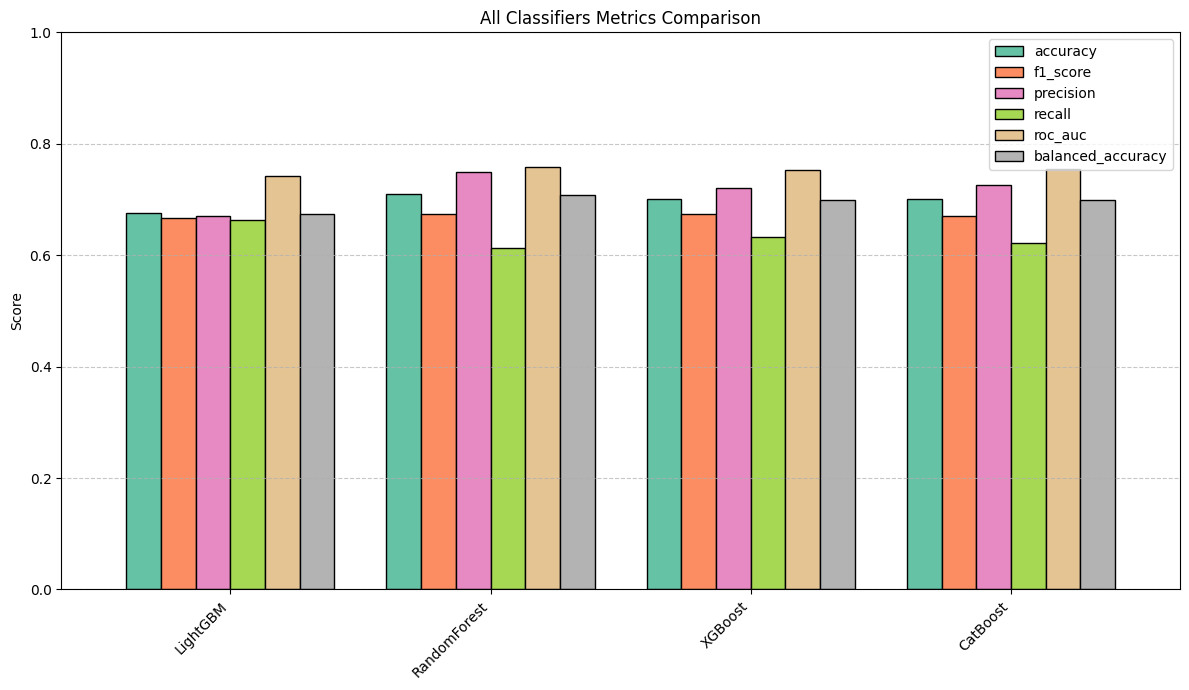

In [40]:
metrics = [
    "accuracy",
    "f1_score",
    "precision",
    "recall",
    "roc_auc",
    "balanced_accuracy",
]

fig, ax = plt.subplots(figsize=(12, 7))
df_results[metrics].plot(
    kind="bar", ax=ax, colormap="Set2", width=0.8, edgecolor="black"
)

ax.set_title("All Classifiers Metrics Comparison")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)
ax.legend(loc="upper right")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
